### We are trying to predict the closing price of the 10th day INFOSYS stock. We have downloaded the INFY stock data from the year 1999 to 2023 using Yahoo Finance. We will be using Deep learning techniques like Recurring neural Networks(RNN), Long-Short Term Memory(LSTM),GRU and Conv1D to predict the stock price.


#### Loading all the required Libraries

In [376]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Conv1D, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping



np.random.seed(1)
tf.random.set_seed(1)

#### Loading the Dataset of INFOSYS

In [377]:
df = pd.read_csv('./data/INFY.csv', parse_dates=['Date'])
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

#### Data Preprocessing

In [378]:
df = df.drop('Date', axis=1)

In [379]:
df.shape

(6069, 6)

In [416]:
df.head(10)

,Open,High,Low,Close,Adj Close,Volume
0,0.583984,0.781250,0.583984,0.732422,0.496774,172512000
1,0.734375,0.761719,0.671875,0.728516,0.494125,39897600
2,0.730469,0.730469,0.658203,0.662109,0.449084,12672000
3,0.667969,0.691406,0.656250,0.656250,0.445110,9984000
4,0.656250,0.699219,0.652344,0.660156,0.447759,15449600
5,0.664063,0.693359,0.654297,0.671875,0.455708,8140800
6,0.679688,0.679688,0.656250,0.656250,0.445110,5747200
7,0.656250,0.687500,0.656250,0.660156,0.447759,6233600
8,0.660156,0.660156,0.629883,0.630859,0.427888,9977600
9,0.638672,0.648438,0.623047,0.636719,0.431863,10969600


In [380]:
closing_prices = df['Close'].values

In [381]:
# Define window size
window_size = 9

#### Creating a function to create input sequences and labels

In [382]:
def create_sequences(df, window_size):
    X = []
    y = []
    for i in range(len(df) - window_size):
        X.append(df[i:i + window_size])
        y.append(df[i + window_size])
    return np.array(X), np.array(y)

In [383]:
# Create input sequences and labels
X, y = create_sequences(closing_prices, window_size)

#### Split the data into training and test sets

In [384]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


In [385]:
# Reshape input sequences to be 3D for LSTM and GRU input
X_train = np.reshape(X_train, (X_train.shape[0], window_size, 1))
X_test = np.reshape(X_test, (X_test.shape[0], window_size, 1))

## Creating, compiling and fitting an RNN Model

In [386]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.SimpleRNN(64, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation='linear')
])
model.summary()



Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_30 (SimpleRNN)   (None, 9, 32)             1088      
                                                                 
 simple_rnn_31 (SimpleRNN)   (None, 64)                6208      
                                                                 
 dense_33 (Dense)            (None, 1)                 65        
                                                                 
Total params: 7,361
Trainable params: 7,361
Non-trainable params: 0
_________________________________________________________________


In [387]:
# Compile the model with Mean Squared Error loss, Root mean squarred error loss and Nadam optimizer
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()]
)

In [388]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=10, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=450,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/450
133/133 [==============================] - 5s 10ms/step - loss: 6.8289 - mean_squared_error: 6.8289 - root_mean_squared_error: 2.6132 - val_loss: 0.0688 - val_mean_squared_error: 0.0688 - val_root_mean_squared_error: 0.2623
Epoch 2/450
133/133 [==============================] - 1s 7ms/step - loss: 0.0607 - mean_squared_error: 0.0607 - root_mean_squared_error: 0.2464 - val_loss: 0.0710 - val_mean_squared_error: 0.0710 - val_root_mean_squared_error: 0.2665
Epoch 3/450
133/133 [==============================] - 1s 7ms/step - loss: 0.0550 - mean_squared_error: 0.0550 - root_mean_squared_error: 0.2345 - val_loss: 0.0803 - val_mean_squared_error: 0.0803 - val_root_mean_squared_error: 0.2834
Epoch 4/450
133/133 [==============================] - 1s 7ms/step - loss: 0.0539 - mean_squared_error: 0.0539 - root_mean_squared_error: 0.2323 - val_loss: 0.0502 - val_mean_squared_error: 0.0502 - val_root_mean_squared_error: 0.2241
Epoch 5/450
133/133 [==============================] - 1s 7

In [389]:
y_pred = model.predict(X_test) 
y_pred

57/57 [==============================] - 0s 3ms/step


array([[4.3313217],
       [8.07873  ],
       [7.400821 ],
       ...,
       [8.383665 ],
       [8.959734 ],
       [3.527383 ]], dtype=float32)

#### Plot the predicted values vs actual values

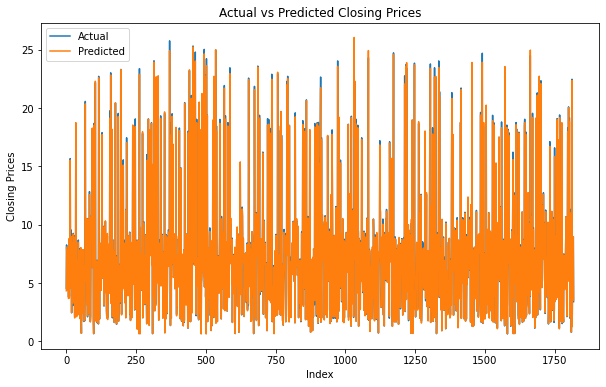

In [390]:

plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Closing Prices')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()



#### Creating an array of the closing price of the past 9 days to predict the closing price of 10th day

In [391]:
prior_days = np.array(
    [
       17.3899, 17.450001, 17.07, 15.4, 15.18, 15.19, 14.96, 14.82, 14.85
        
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 9, 1) 



#### Using the RNN model to Predict the closing price of the 10th day

In [392]:
model.predict(prior_days)

Day10_ClosingPrice_RNN = model.predict(prior_days)[0][0]

1/1 [==============================] - 0s 22ms/step


In [393]:
print(f"Tomorrow's predicted closing price is {Day10_ClosingPrice_RNN:.2f} .")

Tomorrow's predicted closing price is 14.82 .


## Creating, compiling and fitting an LSTM Model

In [394]:
LSTMmodel = keras.models.Sequential([
    keras.layers.LSTM(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.LSTM(32, activation='relu', return_sequences=False),
    keras.layers.Dense(1, activation=None)
])
LSTMmodel.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 9, 32)             4352      
                                                                 
 lstm_11 (LSTM)              (None, 32)                8320      
                                                                 
 dense_34 (Dense)            (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [395]:
np.random.seed(42)
tf.random.set_seed(42)

LSTMmodel.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()]
)

In [396]:
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.0, patience=10, verbose=1, mode='min')

history = LSTMmodel.fit(
    X_train, 
    y_train, 
    epochs=400,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/400
133/133 [==============================] - 5s 14ms/step - loss: 7.5291 - mean_squared_error: 7.5291 - root_mean_squared_error: 2.7439 - val_loss: 0.1933 - val_mean_squared_error: 0.1933 - val_root_mean_squared_error: 0.4397
Epoch 2/400
133/133 [==============================] - 1s 11ms/step - loss: 0.1652 - mean_squared_error: 0.1652 - root_mean_squared_error: 0.4065 - val_loss: 0.1628 - val_mean_squared_error: 0.1628 - val_root_mean_squared_error: 0.4035
Epoch 3/400
133/133 [==============================] - 1s 11ms/step - loss: 0.1362 - mean_squared_error: 0.1362 - root_mean_squared_error: 0.3691 - val_loss: 0.1389 - val_mean_squared_error: 0.1389 - val_root_mean_squared_error: 0.3727
Epoch 4/400
133/133 [==============================] - 1s 11ms/step - loss: 0.1077 - mean_squared_error: 0.1077 - root_mean_squared_error: 0.3282 - val_loss: 0.3640 - val_mean_squared_error: 0.3640 - val_root_mean_squared_error: 0.6034
Epoch 5/400
133/133 [==============================] - 1

Epoch 36/400
133/133 [==============================] - 1s 11ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - root_mean_squared_error: 0.2039 - val_loss: 0.0480 - val_mean_squared_error: 0.0480 - val_root_mean_squared_error: 0.2191
Epoch 37/400
133/133 [==============================] - 1s 11ms/step - loss: 0.0426 - mean_squared_error: 0.0426 - root_mean_squared_error: 0.2065 - val_loss: 0.0504 - val_mean_squared_error: 0.0504 - val_root_mean_squared_error: 0.2246
Epoch 38/400
133/133 [==============================] - 1s 11ms/step - loss: 0.0425 - mean_squared_error: 0.0425 - root_mean_squared_error: 0.2061 - val_loss: 0.0456 - val_mean_squared_error: 0.0456 - val_root_mean_squared_error: 0.2135
Epoch 39/400
133/133 [==============================] - 1s 11ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - root_mean_squared_error: 0.2049 - val_loss: 0.0391 - val_mean_squared_error: 0.0391 - val_root_mean_squared_error: 0.1977
Epoch 40/400
133/133 [==============================

In [397]:
y_pred = LSTMmodel.predict(X_test) 
y_pred

57/57 [==============================] - 1s 4ms/step


array([[4.3163133],
       [8.009066 ],
       [7.3378687],
       ...,
       [8.299161 ],
       [8.880174 ],
       [3.5089972]], dtype=float32)

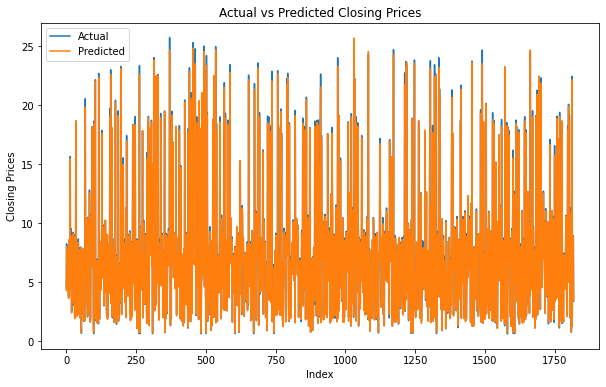

In [398]:
# Plot the predicted values vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Closing Prices')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

#### Using the LSTM model to Predict the closing price of the 10th day

In [399]:
LSTMmodel.predict(prior_days)

Day10_ClosingPrice_LSTM = LSTMmodel.predict(prior_days)[0][0]

1/1 [==============================] - 0s 22ms/step


In [400]:
print(f"Tomorrow's predicted closing price is {Day10_ClosingPrice_LSTM:.2f} .")

Tomorrow's predicted closing price is 14.74 .


## Creating, compiling and fitting an GRU Model

In [401]:
# Create GRU model
GRUmodel = keras.models.Sequential([
    GRU(32, activation='relu', return_sequences=True, input_shape=[9, 1]),
    keras.layers.Dropout(0.2),  # Add dropout regularization
    GRU(32, activation='relu', return_sequences=False),
    keras.layers.Dropout(0.2),  # Add dropout regularization
    keras.layers.Dense(1, activation=None)
])
GRUmodel.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_10 (GRU)                (None, 9, 32)             3360      
                                                                 
 dropout_20 (Dropout)        (None, 9, 32)             0         
                                                                 
 gru_11 (GRU)                (None, 32)                6336      
                                                                 
 dropout_21 (Dropout)        (None, 32)                0         
                                                                 
 dense_35 (Dense)            (None, 1)                 33        
                                                                 
Total params: 9,729
Trainable params: 9,729
Non-trainable params: 0
_________________________________________________________________


In [402]:
# Compile the model with Mean Squared Error loss and Nadam optimizer
GRUmodel.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()]
)

In [403]:
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.0, patience=10, verbose=1, mode='min')

history = GRUmodel.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
133/133 [==============================] - 5s 13ms/step - loss: 21.4668 - mean_squared_error: 21.4668 - root_mean_squared_error: 4.6332 - val_loss: 0.2139 - val_mean_squared_error: 0.2139 - val_root_mean_squared_error: 0.4625
Epoch 2/600
133/133 [==============================] - 1s 11ms/step - loss: 2.1028 - mean_squared_error: 2.1028 - root_mean_squared_error: 1.4501 - val_loss: 0.7994 - val_mean_squared_error: 0.7994 - val_root_mean_squared_error: 0.8941
Epoch 3/600
133/133 [==============================] - 1s 11ms/step - loss: 1.9258 - mean_squared_error: 1.9258 - root_mean_squared_error: 1.3877 - val_loss: 0.9571 - val_mean_squared_error: 0.9571 - val_root_mean_squared_error: 0.9783
Epoch 4/600
133/133 [==============================] - 1s 11ms/step - loss: 1.6700 - mean_squared_error: 1.6700 - root_mean_squared_error: 1.2923 - val_loss: 0.5553 - val_mean_squared_error: 0.5553 - val_root_mean_squared_error: 0.7452
Epoch 5/600
133/133 [==============================] -

In [404]:
y_pred = GRUmodel.predict(X_test) 
y_pred

57/57 [==============================] - 0s 4ms/step


array([[4.472854 ],
       [7.4597917],
       [6.8510485],
       ...,
       [7.5870156],
       [8.120871 ],
       [3.3782787]], dtype=float32)

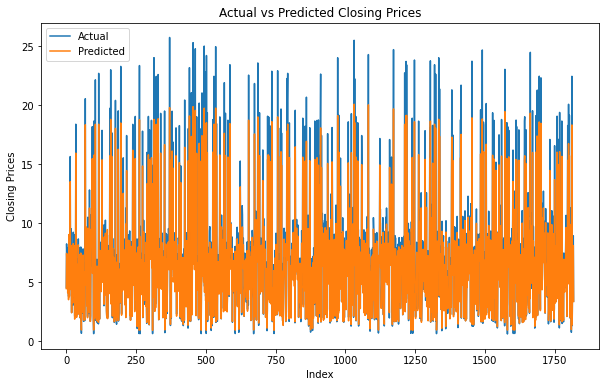

In [405]:
# Plot the predicted values vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Closing Prices')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

#### Using the GRU model to Predict the closing price of the 10th day

In [406]:
GRUmodel.predict(prior_days)

Day10_ClosingPrice_GRU = GRUmodel.predict(prior_days)[0][0]

1/1 [==============================] - 0s 23ms/step


In [407]:
print(f"Tomorrow's predicted closing price is {Day10_ClosingPrice_GRU:.2f} .")

Tomorrow's predicted closing price is 13.46 .


## Creating, compiling and fitting an Conv1D Model


In [408]:
# Create Conv1D model
Conv1Dmodel = keras.models.Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=[9, 1]),
    MaxPooling1D(pool_size=2),
    Flatten(),
    keras.layers.Dropout(0.2),  # Add dropout regularization
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),  # Add dropout regularization
    keras.layers.Dense(1, activation=None)
])
Conv1Dmodel.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, 7, 32)             128       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 3, 32)            0         
 1D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 96)                0         
                                                                 
 dropout_22 (Dropout)        (None, 96)                0         
                                                                 
 dense_36 (Dense)            (None, 32)                3104      
                                                                 
 dropout_23 (Dropout)        (None, 32)                0         
                                                     

In [409]:
# Compile the model with Mean Squared Error loss and Nadam optimizer
Conv1Dmodel.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()]
)

In [410]:
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.0, patience=10, verbose=1, mode='min')

history = Conv1Dmodel.fit(
    X_train, 
    y_train, 
    epochs=600,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/600
133/133 [==============================] - 2s 5ms/step - loss: 9.8924 - mean_squared_error: 9.8924 - root_mean_squared_error: 3.1452 - val_loss: 0.2215 - val_mean_squared_error: 0.2215 - val_root_mean_squared_error: 0.4706
Epoch 2/600
133/133 [==============================] - 0s 4ms/step - loss: 3.4364 - mean_squared_error: 3.4364 - root_mean_squared_error: 1.8537 - val_loss: 0.5717 - val_mean_squared_error: 0.5717 - val_root_mean_squared_error: 0.7561
Epoch 3/600
133/133 [==============================] - 0s 3ms/step - loss: 2.7275 - mean_squared_error: 2.7275 - root_mean_squared_error: 1.6515 - val_loss: 0.6019 - val_mean_squared_error: 0.6019 - val_root_mean_squared_error: 0.7758
Epoch 4/600
133/133 [==============================] - 0s 4ms/step - loss: 2.3161 - mean_squared_error: 2.3161 - root_mean_squared_error: 1.5219 - val_loss: 0.3620 - val_mean_squared_error: 0.3620 - val_root_mean_squared_error: 0.6017
Epoch 5/600
133/133 [==============================] - 0s 4m

In [411]:
y_pred = Conv1Dmodel.predict(X_test) 
y_pred

57/57 [==============================] - 0s 2ms/step


array([[4.8176727],
       [8.087911 ],
       [7.3603516],
       ...,
       [8.210199 ],
       [8.778004 ],
       [3.5747743]], dtype=float32)

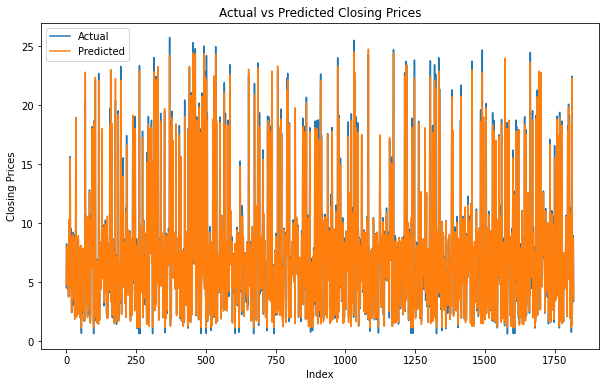

In [412]:
# Plot the predicted values vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Index')
plt.ylabel('Closing Prices')
plt.title('Actual vs Predicted Closing Prices')
plt.legend()
plt.show()

#### Using the RNN model to Predict the closing price of the 10th day

In [413]:
Conv1Dmodel.predict(prior_days)

Day10_ClosingPrice_Conv1D = Conv1Dmodel.predict(prior_days)[0][0]

1/1 [==============================] - 0s 20ms/step


In [414]:
print(f"Tomorrow's predicted closing price is {Day10_ClosingPrice_Conv1D:.2f} .")

Tomorrow's predicted closing price is 15.69 .


In [415]:
# Create a dictionary to store the predictions
predictions = {
    'Model': ['RNN', 'LSTM', 'GRU', 'Conv1D'],
    'Closing Price Prediction': [Day10_ClosingPrice_RNN, Day10_ClosingPrice_LSTM,
                                  Day10_ClosingPrice_GRU, Day10_ClosingPrice_Conv1D]
}

# Create a DataFrame from the dictionary
df_predictions = pd.DataFrame(predictions)

# Print the DataFrame in table format
print(df_predictions)

    Model  Closing Price Prediction
0     RNN                 14.822566
1    LSTM                 14.739736
2     GRU                 13.455151
3  Conv1D                 15.691915


#### Based on the actual closing price on the 10th day (14.87) and the predictions of our models, we can draw the following conclusions:

#### 1.RNN and LSTM models have predicted closing prices that are relatively close to the actual closing price of 14.87. These models have shown relatively good accuracy in predicting the closing price.

#### 2.GRU model has predicted a closing price of 13.455151, which is significantly lower than the actual closing price of 14.87. This indicates that the GRU model may not be performing well in capturing the underlying patterns in the data and making accurate predictions.

#### 3.Conv1D model has predicted a closing price of 15.691915, which is higher than the actual closing price of 14.87. This suggests that the Conv1D model may be overestimating the closing price.

#### Overall, RNN and LSTM models seem to be performing best in predicting the closing price compared to GRU and Conv1D models. However, it's important to note that the accuracy of these models may vary depending on various factors such as hyperparameter tuning, training data size, and model architecture.